# By State EPI Information

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import os
import shutil
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
s=Service(ChromeDriverManager().install())
import scipy
from scipy import stats
import matplotlib.pyplot as plt

import dataframe_image as dfi

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


## 1. Webscraping Information and Creating Dataframes/Reformatting

In [2]:
# logistics
og_directory = os.getcwd()
states_significance_df = pd.read_excel('By State EPI/states_significance.xlsx')
states_significance_df = states_significance_df.drop(columns=['Unnamed: 0'])
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

In [3]:
# webscrapes information and creates dataframes with epi information
def webscrape_df(year, state, geo_title):
    geo = geo_title
    s=Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=s)
    base_url = 'https://www.eeoc.gov/statistics/employment/jobpatterns/eeo1/'
    url = base_url + str(year)
    driver.get(url)
    element_dropdown = driver.find_element_by_id("edit-scope")
    select = Select(element_dropdown)
    # SELECTS OVERARCHING SECTION 
    dir(select)
    try:
        select.select_by_visible_text("States, All Industries")
        driver.find_element_by_xpath('//*[(@id = "edit-submit")]').click()
    except NoSuchElementException:
        print('The item does not exist')
    
    # SELECTS STATE (make into function)
    element_dropdown1 = driver.find_element_by_id("edit-state")
    select = Select(element_dropdown1)
    try:
        select.select_by_visible_text(state) # needs to click by name -- think I can figure that out
        driver.find_element_by_xpath('//*[(@id = "edit-submit")]').click() # clicks on state
    except NoSuchElementException:
        print('The item does not exist')

    # read html of page we navigated to
    html = driver.page_source
    driver.close() # we'll close the browser for now
    soup = BeautifulSoup(html, "html.parser")
    html_headers = soup.find_all(scope="col")
    headers = [html_headers[i].get_text() for i in range(len(html_headers))]

    # read ethnic groups from html & format for dataframe
    html_ethnic_groups = soup.find_all(scope="rowgroup")
    ethnic_groups = [html_ethnic_groups[i].get_text() for i in range(len(html_ethnic_groups))]
    ethnic_groups = np.repeat(ethnic_groups, 2)
    # read gender groups from html & format for dataframe
    html_gender_groups = soup.find_all(scope="row")
    gender_groups = [html_gender_groups[i].get_text() for i in range(len(html_gender_groups))]

    # getting the numbers for the datframe
    html_data = soup.find_all("tr")
    data = [""]*len(ethnic_groups)
    count = 0
    for i in range(len(html_data)):
        temp_data = html_data[i].find_all("td")
        if len(temp_data) != 0:
            temp_list = [temp_data[i].get_text().replace(",","") for i in range(len(temp_data))]
            for j in range(len(temp_list)):
                if len(temp_list[j]) == 0:
                    temp_list[j] = 0
                else:
                    temp_list[j] = int(temp_list[j])
            data[count] = temp_list
            count +=1
        
    # combining everything into a dataframe
    final_df = pd.DataFrame(data, columns = headers[1:])
    final_df.index = ethnic_groups
    final_df.index.name = headers[0]
    
    final_df.index.name = "Racial/Ethnic_Group"

    final_df["entry_workers"] = final_df.iloc[:,3:11].sum(axis=1)
    # only need executives, managers, professionals, entry workers
    final_df = final_df.drop(
        columns=['Technicians',
           'Sales Workers', 'Office & Clerical Workers', 'Craft Workers',
           'Operatives', 'Laborers', 'Service Workers'],
        axis = 1,
    )
    final_df = final_df.fillna(0)
    
    # non gender separated df
    ethnic_df = final_df.groupby('Racial/Ethnic_Group')
    ethnic_df = ethnic_df.sum()
    totals = list(ethnic_df.sum(axis = 0, skipna = True))
    col_names = list(ethnic_df.columns)
    for i in range(len(ethnic_df.columns)):
        ethnic_df[col_names[i]] = ethnic_df[col_names[i]] / totals[i]
    ethnic_df['EPI'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['Professionals']
    ethnic_df['Managers_to_Execs'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['First/Mid Level Officials & Managers']
    ethnic_df['Professionals_to_Managers'] = ethnic_df['First/Mid Level Officials & Managers'] / ethnic_df['Professionals']
    ethnic_df['EPI_ew'] = ethnic_df['Executive/Senior Level Officials & Managers'] / ethnic_df['entry_workers']
    ethnic_df['parity_diff'] = ethnic_df['EPI'] - 1
    print(year)
    return ethnic_df

## 2. Data Analysis (Tests for Significance)
Calculates the EPI of each state. Conducts welch's t-test and counts number of groups that the Asian EPI is significantly less than (as opposed to equal to).

In [4]:
def analyze_state_epi(state):
    geo_title= "all_states"
    start_year = 2009
    end_year = 2018

    # not inputs, but impacted by inputs
    years = list(range(start_year,end_year + 1))
    geo_folder_name = "By State EPI/" + geo_title
    state_folder_name = state
    path_name = geo_folder_name + "/" + state_folder_name
    # we did not read in certain ethnicities (nor do we use), so we add dummy values
    # we assume that it is a constant increase/decrease in population percentage between decades
    if os.path.isdir(geo_folder_name):
        os.chdir(geo_folder_name)
        if os.path.isdir(state_folder_name):
            shutil.rmtree(state_folder_name)
        os.makedirs(state_folder_name)
        os.chdir(state_folder_name)
        print("Directory already exists. Let's remove all the files.")
    else:
        os.makedirs(path_name)
        os.chdir(path_name)
        print("Directory does not exist. We then make new directory.")

    s=Service(ChromeDriverManager().install())

    # CREATING DATAFRAMES
    # PART 2 MANIPULATING THE DATA
    df_list =  [""] * len(years)
    for i in range(len(years)):
        df_list[i] = webscrape_df(years[i], state, geo_title)
    year = years[0]
    parity_diff_df = df_list[0]['parity_diff']
    parity_diff_df = parity_diff_df.rename(str(year))
    epi_df = df_list[0]['EPI']
    epi_df = epi_df.rename(str(year))
    exec_df = df_list[0]['Managers_to_Execs']
    exec_df = exec_df.rename(str(year))
    managers_df =df_list[0]['Professionals_to_Managers']
    managers_df = managers_df.rename(str(year))
    epi_ew_df = df_list[0]['EPI_ew']
    epi_ew_df = epi_ew_df.rename(str(year))
    entry_df = df_list[0]['entry_workers']
    entry_df = entry_df.rename(str(year))
    for i in range(1,len(df_list)):
        year+=1
        temp1 = df_list[i]['parity_diff']
        temp1 = temp1.rename(str(year))
        parity_diff_df = pd.concat([parity_diff_df, temp1], axis = 1)
        temp2 = df_list[i]['EPI']
        temp2 = temp2.rename(str(year))
        epi_df = pd.concat([epi_df, temp2], axis = 1)
        temp3 = df_list[i]['Managers_to_Execs']
        temp3 = temp3.rename(str(year))
        exec_df = pd.concat([exec_df, temp3], axis = 1)
        temp5 = df_list[i]['EPI_ew']
        temp5 = temp5.rename(str(year))
        epi_ew_df = pd.concat([epi_ew_df, temp5], axis = 1)
        temp6 = df_list[i]['entry_workers']
        temp6 = temp6.rename(str(year))
        entry_df = pd.concat([entry_df, temp6], axis = 1)
        temp7 = df_list[i]['Professionals_to_Managers']
        temp7 = temp7.rename(str(year))
        managers_df = pd.concat([managers_df, temp7], axis = 1)

    drop_indices = ['AMERICAN INDIAN', 'HAWAIIAN', 'TWO OR MORE RACES']
    parity_diff_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    epi_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    exec_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    epi_ew_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    entry_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    managers_df.drop(
        labels=drop_indices,
        axis = 0,
        inplace=True)
    csv_title = state + "_epi.csv"
    rounded_epi_df = epi_df.round(decimals=3)
    rounded_epi_df.to_csv(csv_title)

    csv_title = state + "_epi_transpose.txt"
    rounded_epi_df = epi_df.round(decimals=3)
    rounded_epi_df.transpose().to_csv(csv_title)

    # PART 3: CREATING VISUALIZATIONS
    # The EPI, defined as a ratio of the
    ## percentage representation of a company’s Executive workforce relative to that company’s percentage representation of its
    ## entry-level Professional workforce
    epi_df = epi_df.transpose()
    parity_diff_df = parity_diff_df.transpose()
    exec_df = exec_df.transpose()
    epi_ew_df = epi_ew_df.transpose()
    entry_df = entry_df.transpose()
    managers_df = managers_df.transpose()
    plt.plot(epi_df)
    plt.legend(labels = epi_df.columns)
    plt.title('Executive Parity Index by Ethnicity Group')
    plt.xlabel('Year')
    plt.ylabel('Ratios')
    name = state+"_EPI.png"
    plt.savefig(name)
    plt.show()

    # basically the epi graph but subtract 1 so that 0 is the baseline/target

    # parity_diff_df.plot.line()
    plt.plot(parity_diff_df)
    plt.plot([0,9], [0, 0], '-', lw=1)
    plt.legend(labels = parity_diff_df.columns)
    plt.title('Parity Index by Ethnicity Group')
    plt.xlabel('Year')
    plt.ylabel('Ratios')
    plt.show()

    # TEST
    # Welch's t test (variances not equal, sample size less than 10)
    white_epi = epi_df["WHITE"]
    asian_epi = epi_df["ASIAN"]
    hispanic_epi = epi_df["HISPANIC"]
    black_epi = epi_df["BLACK"]

    black_test = scipy.stats.ttest_ind(a=black_epi, b=asian_epi, equal_var=False, alternative = 'greater')
    hispanic_test = scipy.stats.ttest_ind(a=hispanic_epi, b=asian_epi, equal_var=False, alternative = 'greater')
    white_test = scipy.stats.ttest_ind(a=white_epi, b=asian_epi, equal_var=False, alternative = 'greater')
    t_statistic = np.array([black_test[0], hispanic_test[0], white_test[0]])
    p_value = np.array([black_test[1], hispanic_test[1], white_test[1]])
    t_test_df = pd.DataFrame({'t statistic': t_statistic, 'p value': p_value}, columns=['t statistic', 'p value'], index = ["Black", "Hispanic", "White"])
    new_name = state + "_ttest.png"
    t_test_df = t_test_df.round(3) # rounding values for visual purposes

    dfi.export(t_test_df, new_name)

    significance_count = sum(t_test_df.iloc[:,1] < .05)
    print(significance_count)
    os.chdir(og_directory)

    states_significance_df.loc[len(states_significance_df.index)] = [state, significance_count]

## 3. Runs functions for each state.
This may take a while! (depending on number of states you input)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache
[WDM] - 

[WDM] - ====== WebDriver manager ======


Directory already exists. Let's remove all the files.


[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache
<ipython-input-3-b4fdfaaeb06c>:9: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element_dropdown = driver.find_element_by_id("edit-scope")
<ipython-input-3-b4fdfaaeb06c>:15: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//*[(@id = "edit-submit")]').click()
<ipython-input-3-b4fdfaaeb06c>:20: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element_dropdown1 = driver.find_element_by_id("edit-state")
<ipython-input-3-b4fdfaaeb06c>:24: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_xpath('//*[(@id = "edit-submit")]').cli

2009


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2010


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2011


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2012


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735


2013


[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2014


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2015


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2016


[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/christinehamakawa/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


2017
2018


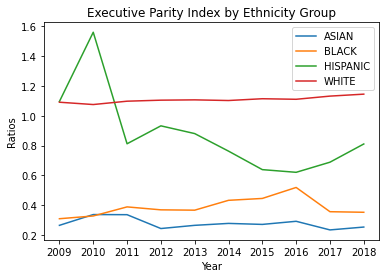

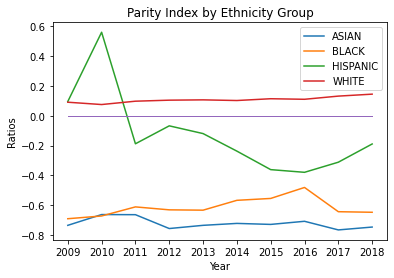

3


In [5]:
for s in ['Arkansas']: # for all states, use state_names
    os.chdir(og_directory)
    analyze_state_epi(s)

## 4. Save information and Merge with Asian Population Data

In [6]:
# saves information in new file
states_significance_df.to_excel('By State EPI/states_sig_final.xlsx')

In [7]:
# not used and updated
asian_pop_df = pd.read_csv('By State EPI/asianPercPop.csv')
# for context, we merge states significance count with asian population data
merged_inner = pd.merge(left=states_significance_df, right=asian_pop_df, left_on='state', right_on='State')
merged_inner=merged_inner.drop(columns=['State'])
print(merged_inner)
merged_inner.to_excel('By State EPI/states_epi_asian_data.xlsx')

      state  significance_level  AsianTotal  AsianPerc
0  Arkansas                 3.0       57895      0.019


In [8]:
# only run if all states (state_names) are used
sum(merged_inner['significance_level'] == 3) / 49

0.02040816326530612